### A1: Data Curation
For this assignment, you combine data about Wikipedia page traffic from two different [Wikimedia REST API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) endpoints into a single dataset, perform some simple data processing steps on the data, and then analyze that data

Executing each cell **sequentially** (Shift + Enter)  or use **Kernel >> Restart & Run all**

#### Step 1: Load neccessary packages
For the purpose of fetching data, processing and analyzing it, we require the following packages:
1. [requests](https://requests.readthedocs.io/en/master/user/install/) - Enables python code to access the API using GET, POST, UPDATE or DELETE request
2. json - Enables python code to access the json object from the request and save it
3. csv - Enables python code to create CSV files for the different types of data
4. [pandas](https://pandas.pydata.org/docs/getting_started/install.html) - Enables python code to load data from csv files and perform necessary data processing
5. [matplotlib](https://matplotlib.org/users/installing.html) - Enables python code to create visualizations and graphs

In [1]:
import requests as re
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

#### Step 2: Use the API documentation and endpoints to get the data
1. Page Views API - [Documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) <br />
It contains page views from 2015/07/01 to current date. We measure only user interactions
<br />
<br />
2. Page Counts API - [Documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) <br />
It contains legacy page counts from 2008/01/01 to 2016/07/30. We measure all interaction including but not limited to users, crawlers etc.
<br />
<br />
Since we need to get the data we use the **request.get** method and parameters based on the above documentations

In [2]:
## Page Views
r = re.get('https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/all-access/user/monthly/2015070100/2020093000')
r_mobile_web = re.get('https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/mobile-web/user/monthly/2015070100/2020093000')
r_mobile_app = re.get('https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/mobile-app/user/monthly/2015070100/2020093000')
r_desktop = re.get('https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/desktop/user/monthly/2015070100/2020093000')

In [3]:
## Page Count from 
r_legacy = re.get('https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/all-projects/all-sites/monthly/2008010100/2016073000')
r_legacy_desktop = re.get('https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/all-projects/desktop-site/monthly/2008010100/2016073000')
r_legacy_mobile = re.get('https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/all-projects/mobile-site/monthly/2008010100/2016073000')

#### Step 3: Function to save raw json output and csv output

Create a function that enables the python code to extract data from each request and save it in both **json** and **csv** file format.

In [4]:
def createJsonAndCsv(request, fileName):
    with open(fileName+'.json', 'w') as outfile:
        json.dump(request.json(), outfile)
    
    pageView = request.json()['items']
    csv_file = open(fileName+'.csv', 'w')
    csv_writer = csv.writer(csv_file)
    count = 0
    for month in pageView:
        if count == 0:
            # Writing headers of CSV file 
            header = month.keys()
            csv_writer.writerow(header)
            count += 1
        # Writing data of CSV file 
        csv_writer.writerow(month.values())
    csv_file.close()

#### Step 4: List all the request variables used before
A dictionary is a data structure that stores value in the form of key-value pair

Create a dictionary variable such that the key is the request variable and the value is file name you want

For example: 
...
* ***key*** = r, ***value*** = 'pageviews_all-access_201507-202009'
* ***key*** = r_legacy_desktop, ***value*** = 'pagecounts_desktop-site_200801-201607'

In [5]:
requestFile = {
    r: 'pageviews_all-access_201507-202009',
    r_mobile_web: 'pageviews_mobile-web_201507-202009',
    r_mobile_app: 'pageviews_mobile-app_201507-202009',
    r_desktop: 'pageviews_desktop_201507-202009',
    r_legacy: 'pagecounts_all-access_200801-201607',
    r_legacy_desktop: 'pagecounts_desktop-site_200801-201607',
    r_legacy_mobile:'pagecounts_mobile-site_200801-201607'
}

#### Step 5: Run a loop over all request objects

We execute the **createJsonAndCsv** function for each request object using a for loop

In [6]:
requests = list(requestFile.keys())

for request in requests:
    createJsonAndCsv(request, str(requestFile.get(request)))


#### Step 6: Read the csv files created 

Read all the comma seperated(csv) files created by the above code

In [7]:
pageViews_mobileweb = pd.read_csv('pageviews_mobile-web_201507-202009.csv')
pageViews_mobileapp = pd.read_csv('pageviews_mobile-app_201507-202009.csv')
pageViews_allAccess = pd.read_csv('pageviews_all-access_201507-202009.csv')
pageViews_desktop = pd.read_csv('pageviews_desktop_201507-202009.csv')
pageCounts_allAccess = pd.read_csv('pagecounts_all-access_200801-201607.csv')
pageCounts_desktop = pd.read_csv('pagecounts_desktop-site_200801-201607.csv')
pageCounts_mobile = pd.read_csv('pagecounts_mobile-site_200801-201607.csv')


#### Step 7: Add mobile web and app views

1. Sort the mobile app and mobile web views by the column 'timestamp'
2. Create a new dataframe for total mobile views
3. Create common columns in the total mobile dataframe from the mobile app and mobile web dataframe
4. Add the views of mobile app and mobile web for the same month

In [8]:
pageViews_mobileweb = pageViews_mobileweb.sort_values(by=['timestamp'])
pageViews_mobileapp = pageViews_mobileapp.sort_values(by=['timestamp'])

pageViews_mobile = pd.DataFrame()
pageViews_mobile['project'] = pageViews_mobileweb['project']
pageViews_mobile['access'] = 'mobile'
pageViews_mobile['agent'] = pageViews_mobileweb['agent']
pageViews_mobile['granularity'] = pageViews_mobileweb['granularity']
pageViews_mobile['timestamp'] = pageViews_mobileweb['timestamp']
pageViews_mobile['views'] = pageViews_mobileweb['views'] + pageViews_mobileapp['views']

#### Step 8: Data processing - Extract year and month

The function allows python code to extract year and month from 'timestamp' column.
... Parameters:
* ***dataframe***: dataframe you want to execute the function on
* ***flag***: 0 for extracting views, 1 for extracting counts

Steps used in the function:
1. The API returns a date format of type YYYYMMDDHH
2. To extract year and month, we convert the 'timestamp' column to string
3. The first for value of each timestamp are the year
4. The fifth and sixth value of each timestamp are the month
5. Remove all the unecessary columns

In [9]:
def createMonthAndYear(dataframe, flag):
    dataframe['timestamp'] = dataframe['timestamp'].astype(str)
    dataframe['year'] = dataframe['timestamp'].apply(lambda x: int(x[0:4]))
    dataframe['month'] = dataframe['timestamp'].apply(lambda x: int(x[4:6]))
    dataframe['month'] = dataframe['month'].map("{:02}".format)
    dataframe['month'] = dataframe['month'].astype(int)
    if flag == 0:
        return dataframe[["year", "month", "views"]]
    else:
        return dataframe[["year", "month", "count"]]

In [10]:
pageViews_mobile = createMonthAndYear(pageViews_mobile, 0)
pageViews_allAccess = createMonthAndYear(pageViews_allAccess, 0)
pageViews_desktop = createMonthAndYear(pageViews_desktop, 0)
pageCounts_allAccess = createMonthAndYear(pageCounts_allAccess, 1)
pageCounts_desktop = createMonthAndYear(pageCounts_desktop, 1)
pageCounts_mobile = createMonthAndYear(pageCounts_mobile, 1)

#### Step 9: Combine all dataframes

Join all dataframes to create one consolidated wikipedia traffic dataframe

1. Combine all ***pageViews*** dataframe <br />
    Left join ***pageViews_allAccess*** , ***pageViews_desktop*** and ***pageViews_mobile*** for each year and month
<br />

2. Combine all ***pageCounts*** dataframe <br />
    Left join ***pageCounts_allAccess*** , ***pageCounts_desktop*** and ***pageCounts_mobile*** for each year and month)
<br />

3. Combine the consolidated views and count dataframe to create ***wikipedia_traffic*** dataframe <br />
    Outer join ***pageViews*** and ***pageCounts***)

In [11]:
merged = pd.merge(pageCounts_allAccess,pageCounts_desktop, on=['year','month'], how = 'left')
pageCounts = pd.merge(merged, pageCounts_mobile, on=['year','month'], how = 'left')

pageCounts.columns = ['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views']

merged_views = pd.merge(pageViews_allAccess,pageViews_desktop, on=['year','month'], how = 'left')
pageViews = pd.merge(merged_views,pageViews_mobile, on=['year','month'], how = 'left')

pageViews.columns = ['year', 'month', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']

wikipedia_traffic = pd.merge(pageCounts, pageViews, on=['year','month'], how='outer')

wikipedia_traffic.to_csv('en-wikipedia_traffic_200801-202009.csv', header = True)

#### Step 10: Create Visualization

Create a visualization to show the page views and page counts for different years and different means of access

1. Create a date column by appending the month, 1 and the year. <br />
    For example if month = 10, year = 2010, date = 10/1/2010
2. Set the date as the index of the dataframe. This allows us to directly use the **plot** function from pandas to create visualizations
3. Set the figure size to 15 X 7 (use any dimension of your choice)
4. Use **plot** function with suitable attributes to create the chart

In [12]:
wikipedia_traffic['Date'] = pd.to_datetime(wikipedia_traffic['month'].astype(str) + '/' + '1' + '/' + wikipedia_traffic['year'].astype(str), format='%m/%d/%Y')
wikipedia_traffic.set_index('Date')

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
Date,,,,,,,,
2008-01-01,2008,1,9.154429e+09,9.154429e+09,NaN,NaN,NaN,NaN
2008-02-01,2008,2,8.843288e+09,8.843288e+09,NaN,NaN,NaN,NaN
2008-03-01,2008,3,9.191927e+09,9.191927e+09,NaN,NaN,NaN,NaN
2008-04-01,2008,4,9.645857e+09,9.645857e+09,NaN,NaN,NaN,NaN
2008-05-01,2008,5,1.069643e+10,1.069642e+10,6485.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-05-01,2020,5,NaN,NaN,NaN,1.840342e+10,6.777243e+09,1.162617e+10
2020-06-01,2020,6,NaN,NaN,NaN,1.542529e+10,5.756011e+09,9.669275e+09
2020-07-01,2020,7,NaN,NaN,NaN,1.528387e+10,5.388701e+09,9.895168e+09


In [13]:
sns.set(rc={'figure.figsize':(15, 7)})
# wikipedia_traffic = wikipedia_traffic.set_index('Date')

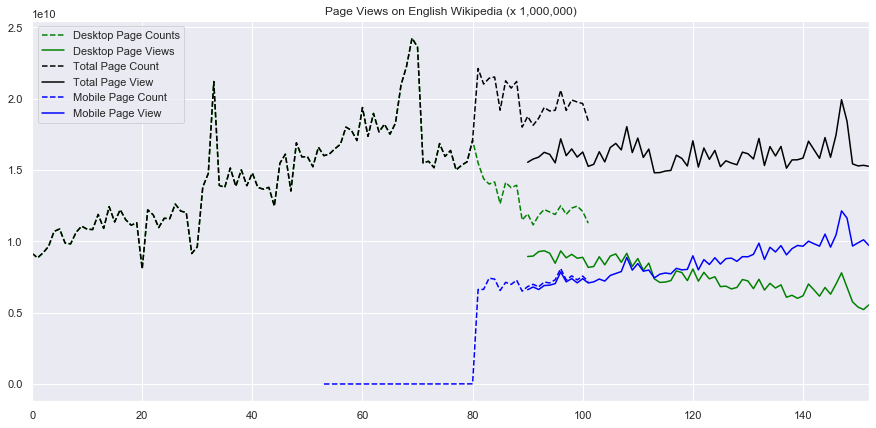

In [14]:
fig, ax = plt.subplots()
# xticks = pd.date_range(datetime.datetime(2008,1,1), datetime.datetime(2020,9,1), freq='YS')
wikipedia_traffic['pagecount_desktop_views'].plot(color = 'green', style = '--', legend = True)
wikipedia_traffic['pageview_desktop_views'].plot(color = 'green', legend = True)

wikipedia_traffic['pagecount_all_views'].plot(color = 'black',style = '--', legend = True)
wikipedia_traffic['pageview_all_views'].plot(color = 'black', title ='Page Views on English Wikipedia (x 1,000,000)', legend = True)

wikipedia_traffic['pagecount_mobile_views'].plot(color = 'blue', style = '--', legend = True)
wikipedia_traffic['pageview_mobile_views'].plot(color = 'blue', legend = True)
# plt.xticks(list(set(wikipedia_traffic.index.year)))
# ax.set_xticklabels([x.strftime('%Y') for x in xticks])re
ax.legend(["Desktop Page Counts", "Desktop Page Views", 'Total Page Count', 'Total Page View', 'Mobile Page Count', 'Mobile Page View'])